In [182]:
import fastbox as fb
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.optimize import newton
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import pandas as pd
from pysabr import Hagan2002LognormalSABR
from pysabr import Hagan2002NormalSABR
from pysabr import hagan_2002_lognormal_sabr as hagan2002LN

$$\sigma(\mathrm{X}, \mathrm{f}) =\frac{\alpha\left[1+\left(\frac{(1-\beta)^2}{24(f X)^{1-\beta}} \alpha^2+\frac{\rho \beta v}{4(f X)^{\frac{1-\beta}{2}}} \alpha+\frac{\left(2-3 \rho^2\right) v^2}{24}\right) T\right]_z}{(f X)^{\frac{1-\beta}{2}}\left[1+\frac{(1-\beta)^2}{24}\left(\ln \frac{f}{X}\right)^2+\frac{(1-\beta)^4}{1920}\left(\ln \frac{f}{X}\right)^4\right]} \frac{z}{x(z)}$$    
$$z=\frac{v}{\alpha}(f K)^{(1-\beta) / 2} \log \frac{f}{K}$$
$$x(z)=\log \frac{\sqrt{1-2 \rho z+z^2}+z-\rho}{1-\rho}$$
For at-the-money (ATM) options, $K=f$, the volatility calculation formula is simplified to:
$$\sigma_{A T M}=\sigma(f, f)=\frac{\alpha}{f^{1-\beta}}\left(1+\left(\frac{(1-\beta)^2}{24 f^{2-2 \beta}} \alpha^2+\frac{\rho \beta v}{4 f^{1-\beta}} \alpha+\frac{\left(2-3 \rho^2\right) v^2}{24}\right) T_{e x}\right)$$

In [164]:
# a、k:strike price
# b、v_sln: initial volatility
# 1、f：forward price
# 2、s:shift
# 3、t:excerse time
# 4、beta
def lognormal_vol(k, f, t, alpha, beta, rho, volvol):
    """
    Hagan's 2002 SABR lognormal vol expansion.

    The strike k can be a scalar or an array, the function will return an array
    of lognormal vols.
    """
    # Negative strikes or forwards
    if k <= 0 or f <= 0:
        return 0.
    eps = 1e-07
    logfk = np.log(f / k)
    fkbeta = (f*k)**(1 - beta)
    a = (1 - beta)**2 * alpha**2 / (24 * fkbeta)
    b = 0.25 * rho * beta * volvol * alpha / fkbeta**0.5
    c = (2 - 3*rho**2) * volvol**2 / 24
    d = fkbeta**0.5
    v = (1 - beta)**2 * logfk**2 / 24
    w = (1 - beta)**4 * logfk**4 / 1920
    z = volvol * fkbeta**0.5 * logfk / alpha
    if abs(z) > eps:
        vz = alpha * z * (1 + (a + b + c) * t) / (d * (1 + v + w) * _x(rho, z))
        return vz
    # ATM
    else:
        v0 = alpha * (1 + (a + b + c) * t) / (d * (1 + v + w))
        return v0

def _x(rho, z):
    """Return function x used in Hagan's 2002 SABR lognormal vol expansion."""
    a = (1 - 2*rho*z + z**2)**.5 + z - rho
    b = 1 - rho
    return np.log(a / b)

In [131]:
forward_price=fb.data.futures.daily(instrumentid = 'CU2110',from_date = '2021-01-01',to_date = '2021-12-31')
option_price = fb.data.futuresoptions.daily(instrumentid = 'CU2110',from_date = '2021-04-16',to_date = '2021-04-16')

In [132]:
# exercise date
foreward_date=option_price.index.get_level_values('maturity')[0].strftime('%Y-%m-%d')
# Futures price on exercise date
forward=forward_price.loc[foreward_date,'close'] # spot price
mat=(option_price.index.get_level_values('maturity')[0]-option_price.index.get_level_values('date')[0]).days
r=0.02

In [135]:
N = norm.cdf
def BS(forward, strike, mat, r, sigma, flag):
    """
    This function returns the BS price for an option on futures Flag = P or C
    We assume that sigma is yearly and r is yearly. mat is the number of days to maturity so tau = mat / 360
    """
    sign = 1
    tau = mat / 360
    discount = np.exp(- r * tau)
    if flag == "P":
        sign = -1
    std_dev = sigma * np.sqrt(tau)

    d1 = np.log(discount*forward/strike) / std_dev + 0.5 * std_dev
    d2 = d1 - std_dev
    result = discount * sign * (forward * N(sign * d1) - strike * N(sign * d2))
    return result

# now for the implied volatility
# remember the put call parity
# BS(call) - BS(put) = discount * (forward - K)
# so if the strike is very high (for the put out of the money) then BS(put) is close to 0. then the corresponding call is equal to BS(call) = disount * (forward - K) - BS(put) and you search the implied vol for this call and strike
# the decision for in/out of the money is if K>forward then call if K<forward then put

def IV(forward, strike, mat, r, price, flag):
    tau = mat / 360
    discount = np.exp(- r * tau)
    if flag == "C" and strike < forward:
        flag = "P"
        price = price - discount *(forward - strike)
    elif flag == "P" and strike >= forward:
        flag = "C"
        price = discount *(forward - strike) + price
    
    def root_func(x):
        return BS(forward, strike, mat, r, x, flag) - price
    sigma = newton(root_func, 0.2)
    return sigma

In [136]:
votility_df = pd.DataFrame() # Recording the results of calculations
strike_price = []
votility_BS = []
flags = []
'''
Unsolvable volatility for deep real-money options
'''
for index in option_price.index:
    try:
        flag=index[2]
        strike=index[3]#strike price
        price=option_price.loc[index,'close']#Option price
        votility=IV(forward, strike, mat, r, price, flag)
        strike_price.append(strike)
        votility_BS.append(votility)
        flags.append(flag)
    except:
        print(index)
votility_df['strike_price'] = strike_price
votility_df['votility_BS'] = votility_BS
votility_df['flags'] = flags
votility_df_new=votility_df.groupby(votility_df['strike_price'], as_index=False).mean()

(Timestamp('2021-04-16 00:00:00'), Timestamp('2021-09-24 00:00:00'), 'C', 43000.0)
(Timestamp('2021-04-16 00:00:00'), Timestamp('2021-09-24 00:00:00'), 'C', 44000.0)
(Timestamp('2021-04-16 00:00:00'), Timestamp('2021-09-24 00:00:00'), 'C', 45000.0)
(Timestamp('2021-04-16 00:00:00'), Timestamp('2021-09-24 00:00:00'), 'C', 46000.0)
(Timestamp('2021-04-16 00:00:00'), Timestamp('2021-09-24 00:00:00'), 'C', 47000.0)
(Timestamp('2021-04-16 00:00:00'), Timestamp('2021-09-24 00:00:00'), 'C', 48000.0)
(Timestamp('2021-04-16 00:00:00'), Timestamp('2021-09-24 00:00:00'), 'C', 49000.0)
(Timestamp('2021-04-16 00:00:00'), Timestamp('2021-09-24 00:00:00'), 'C', 50000.0)
(Timestamp('2021-04-16 00:00:00'), Timestamp('2021-09-24 00:00:00'), 'C', 51000.0)
(Timestamp('2021-04-16 00:00:00'), Timestamp('2021-09-24 00:00:00'), 'C', 52000.0)
(Timestamp('2021-04-16 00:00:00'), Timestamp('2021-09-24 00:00:00'), 'C', 53000.0)
(Timestamp('2021-04-16 00:00:00'), Timestamp('2021-09-24 00:00:00'), 'C', 54000.0)


In [170]:
Strikes = votility_df_new['strike_price']
Vols_BS = votility_df_new['votility_BS']
beta=0.5
# this step we will get alpha, rho, volvol
def vol_square_error(x):
    vols = [lognormal_vol(k_, forward, mat / 360, x[0], beta, x[1],
                          x[2])*100 for k_ in Strikes]
    return sum((vols - Vols_BS)**2)

initial_guess = [0.01, 0.00, 0.10]
x0 = np.array(initial_guess)
bounds = [(0.0001, None), (-0.9999, 0.9999), (0.0001, None)]
res = minimize(vol_square_error, x0, method='L-BFGS-B', bounds=bounds)
alpha, rho, volvol = res.x
votility_df_new['votility_sabr']=[lognormal_vol(k_, forward, mat / 360, alpha, beta, rho,volvol)*100 for k_ in Strikes]

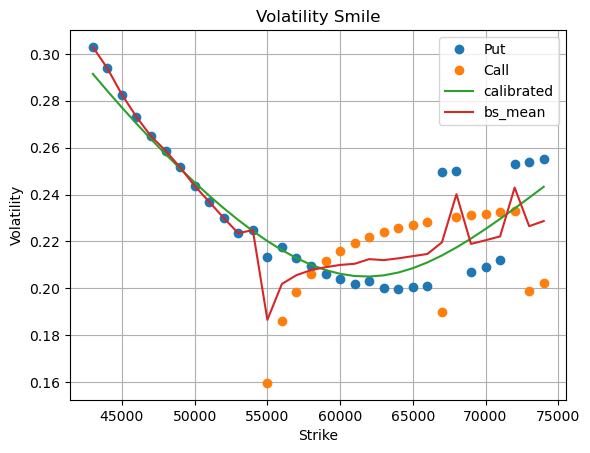

Fitted  alpha, beta, rho, volvol:  [0.584807603884539, 0.5, 0.5099753327421771, 0.013083168653868995]


In [179]:
plt.xlabel('Strike') 
plt.ylabel('Volatility') 
plt.title("Volatility Smile")
plt.plot(votility_df[votility_df['flags']=='P']['strike_price'], votility_df[votility_df['flags']=='P']['votility_BS'], 'o', label='Put')
plt.plot(votility_df[votility_df['flags']=='C']['strike_price'], votility_df[votility_df['flags']=='C']['votility_BS'], 'o', label='Call')
plt.plot(votility_df_new['strike_price'], votility_df_new['votility_sabr'],label='calibrated')
plt.plot(votility_df_new['strike_price'], votility_df_new['votility_BS'],label='bs_mean')
plt.grid(True)  
plt.legend()
plt.show()
print("Fitted  alpha, beta, rho, volvol: ", [alpha,beta, rho, volvol])

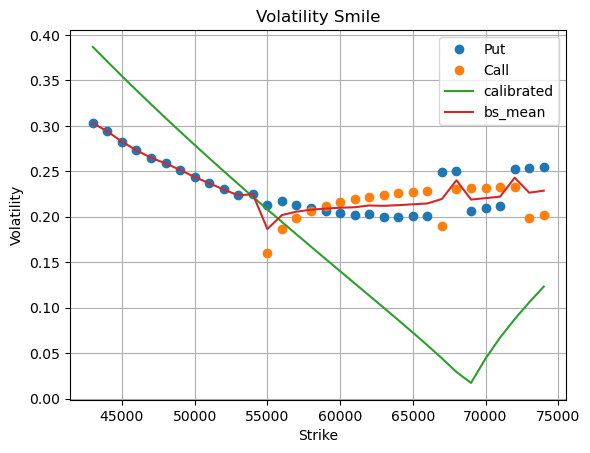

Fitted  alpha, beta, rho, volvol:  [5.432582466776145, 0.5, 0.7612322752260001, 4.8796919470866404]


In [177]:
# this step we will get alpha, rho, volvol
def vol_square_error_(x):
    vols = [lognormal_vol(k_, forward, mat / 360, x[0], beta, x[1],
                          x[2]) for k_ in Strikes]
    return sum((vols - Vols_BS)**2)

initial_guess = [0.01, 0.00, 0.10]
x0 = np.array(initial_guess)
bounds = [(0.0001, None), (-0.9999, 0.9999), (0.0001, None)]
res = minimize(vol_square_error_, x0, method='L-BFGS-B', bounds=bounds)
alpha1, rho1, volvol1 = res.x
votility_df_new['votility_sabr_']=[lognormal_vol(k_, forward, mat / 360, alpha1, beta, rho1,volvol1) for k_ in Strikes]
plt.xlabel('Strike') 
plt.ylabel('Volatility') 
plt.title("Volatility Smile")
plt.plot(votility_df[votility_df['flags']=='P']['strike_price'], votility_df[votility_df['flags']=='P']['votility_BS'], 'o', label='Put')
plt.plot(votility_df[votility_df['flags']=='C']['strike_price'], votility_df[votility_df['flags']=='C']['votility_BS'], 'o', label='Call')
plt.plot(votility_df_new['strike_price'], votility_df_new['votility_sabr_'],label='calibrated')
plt.plot(votility_df_new['strike_price'], votility_df_new['votility_BS'],label='bs_mean')
plt.grid(True)  
plt.legend()
plt.show()
print("Fitted  alpha, beta, rho, volvol: ", [alpha1,beta, rho1, volvol1])

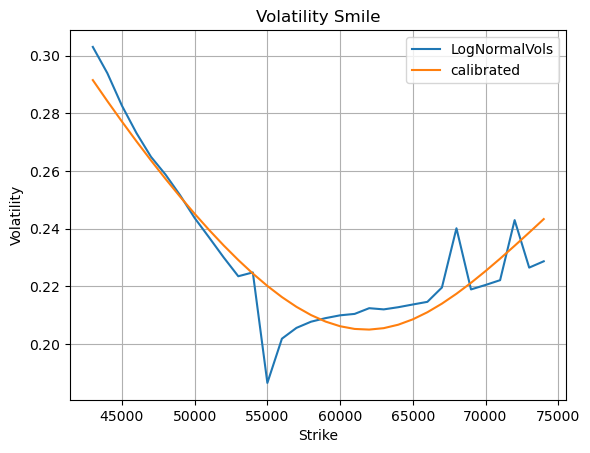

Fitted  alpha, rho, volvol:  [0.584807603884539, 0.5099753327421771, 0.013083168653868995]


In [185]:
# result from pysabr
sabrLognormal = Hagan2002LognormalSABR(f=forward, shift=0, t=mat / 360, beta=0.5)
strikes = votility_df_new['strike_price']
LogNormalVols = votility_df_new['votility_BS']
[alpha2, rho2, volvol2] = sabrLognormal.fit(strikes, LogNormalVols)
calibrate=[hagan2002LN.lognormal_vol(strike, f = forward, t = mat / 360, alpha = alpha2, beta = beta, rho = rho2, volvol = volvol2) * 100.00 for strike in strikes]
plt.xlabel('Strike') 
plt.ylabel('Volatility') 
plt.title("Volatility Smile")
plt.plot(strikes, LogNormalVols,label='LogNormalVols')
plt.plot(strikes, calibrate,label='calibrated')
plt.grid(True)  
plt.legend()
plt.show()

print("Fitted  alpha, rho, volvol: ", [alpha2, rho2, volvol2])